In [1]:
%load_ext autoreload
%autoreload 2

In [194]:
from utils import *

import math
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm.notebook import tqdm
from easydict import EasyDict

device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [218]:
file = '20190819-Kutna Hora-L4-out-MVI_0040'

signal = load_audio(f'data/audio/{file}.wav')
signal_length = int(len(signal) / 44100)

csv = load_csv(f'data/audio/{file}.MP4.csv')
events = load_events_from_csv(csv)
directions = load_direction_from_csv(csv)

try:
    manual_events = load_events(f'data/labels/{file}.txt')
except:
    manual_events = None

events_start_time, events_end_time = load_event_time_from_csv(csv)

In [219]:
def get_melkwargs(params):
    return {
        "n_fft": params.n_fft,
        "n_mels": params.n_mels,
        "hop_length": params.hop_length
    }

def conv(array):
    array = array.view(1, 1, -1)
    kernel = torch.ones(1, 1, 51)
    array = torch.nn.functional.conv1d(array, kernel)
    array = array.squeeze()
    return array

def show(params, signal, events=None, 
         events_start_time=None, events_end_time=None, 
         manual_events=None, directions=None, from_time=0, till_time=86400):
    
    print(f'{from_time // 60:02.0f}:{from_time % 60:02.0f} - {till_time // 60:02.0f}:{till_time % 60:02.0f}')
    
    params.val = get_additional_params(
        params, signal=signal, events=events, start_time=from_time, end_time=till_time
    )
    
    signal = signal[from_time * params.sr: till_time * params.sr]
    
    signal_length = round(len(signal) / params.sr)

    nrows = 3
    width = params.val.time.size // 4
#     width = 100
    height = 4 * nrows
    fig, axes = plt.subplots(nrows=nrows, figsize=(width, height))
    
    ax0, ax1, ax2 = axes
    
    for ax in axes:
        ax.margins(0, 0.02)
        
    x_axis = np.arange(from_time, from_time + signal_length)
    ax0.plot(x_axis, np.zeros(signal_length), marker='o', markersize=3, color='black')
    
    def formatter(x, y):
        return f'{x // 60:02.0f}:{x % 60:02.0f}'

    ax0.xaxis.set_major_formatter(tick.FuncFormatter(formatter))
    
    # show events from eyedea engine
    if events is not None:
        colors = 'violet'
        mask = (events >= from_time) & (events <= till_time)
        events = events[mask]
        
        # color code direction
        if directions is not None:
            colors = ['red' if direction == 'outgoing' else 'green' for direction in directions[mask]]

        ax0.vlines(events, 0, 1, color=colors, linewidth=2.0)
                 
    # show manual annotations
    if manual_events is not None:
        mask = (manual_events >= from_time) & (manual_events <= till_time)
        manual_events = manual_events[mask]
        ax0.vlines(manual_events, 0, 1, color='black', linestyle=':', linewidth=2.0)
        
    # show start and end time of events
    if events_start_time is not None and events_end_time is not None:
        colors = 'violet'
        
        # color code direction
        if directions is not None:
            colors = ['red' if direction == 'outgoing' else 'green' for direction in directions]
        
        for event_start_time, event_end_time, color in zip(events_start_time, events_end_time, colors):
            if from_time <= event_start_time <= till_time and from_time <= event_end_time <= till_time:
                ax0.fill_between([event_start_time, event_end_time], [0], [1], color=color, alpha=0.25);
    
    # plot signal amplitude
    each = 16
    ax1.plot(signal[::each], alpha=0.5)
    
    ax1_1 = ax1.twinx()
    features = torch.stft(signal, n_fft=params.n_fft, hop_length=params.hop_length)
    energy = features[..., 0].pow(2)
    energy = energy.sum(0)
    energy = conv(energy)
    energy -= energy.min()
    energy /= energy.max()

    x_axis = np.linspace(0, len(signal[::each]), len(energy))
    ax1_1.plot(x_axis, energy, c='black')

    # plot spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=params.sr, **get_melkwargs(params))
    features = transform(signal).numpy()
    features = librosa.power_to_db(features, ref=np.max)
    
    ax2.pcolormesh(features)


In [220]:
params = EasyDict()
params.n_fft = 1024
params.n_mels = 64
params.hop_length = 128
params.sr = 44100

params.nn_hop_length = 1
params.frame_length = 1

09:00 - 13:00


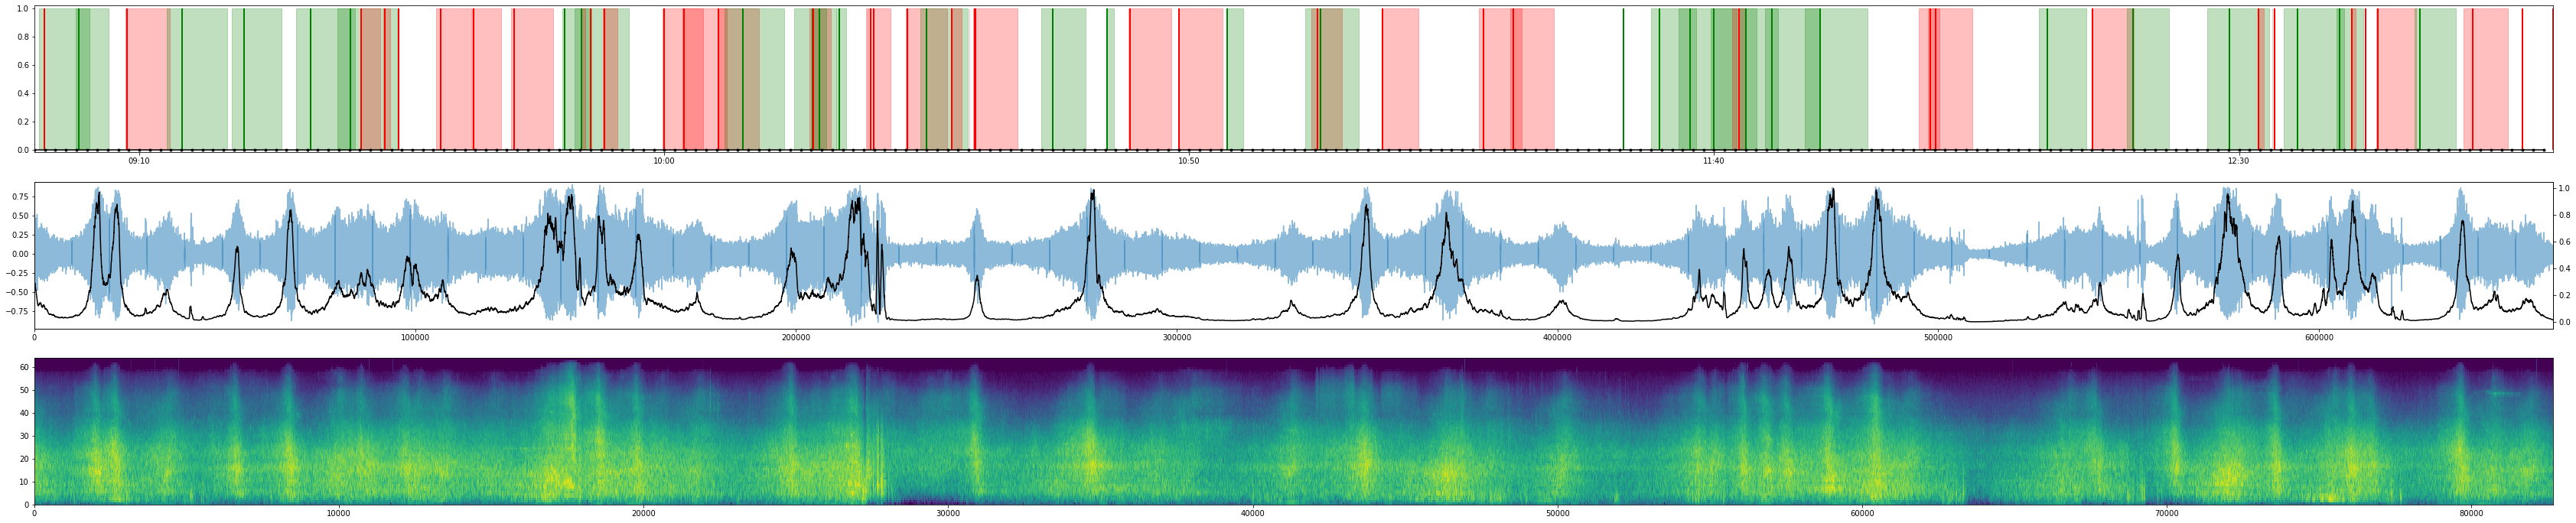

In [221]:
show(
    params,
    signal=signal,
    events=events, 
    events_start_time=events_start_time,
    events_end_time=events_end_time,
    manual_events=manual_events,
    directions=directions,
    from_time=9 * 60,
    till_time=13 * 60,
)